In [1]:
# This is only needed if the notebook is run in VSCode
import nbs_pipeline.utils.vscode  as vs
vs.DisplayHandle.update = vs.update_patch

In [2]:
#use logs file print
#import sys 
#output_file = open('their_logs.txt', 'w')
#sys.stdout = output_file

In [3]:
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!from tchub.all import *
import wandb
wandb_api = wandb.Api()
from fastcore.all import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from dvats.all import *
import nbs.orelm_original.OR_ELM as orelm
import nbs_pipeline.utils.config as cfg


Initialize loss function
Initialize loss function
Initialize loss function


In [4]:
#Import Configuration
config, job_type, dataSet = cfg.get_artifact_config_ORELM(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/02c-encoder_orelm.yaml
... About to replace includes with content
Before configuration reading 
-include: None
-user_preferences:
	-use_wandb: False
	-wdb:
		-user: mi-santamaria
		-project_name: test-project
		-version: 0
		-mode: offline
		-artifacts_path: ./data/wandb_artifacts
	-data:
		-folder: ~/data/
		-fname: speed_6005
		-ftype: .csv
		-cols: [1]
		-freq: 1s
	-artifact:
		-alias: TiltABP
	-directories:
		-tmp: tmp
		-data: ~/data/speed_6005.csv
-data:
	-name: speed_6005
	-path: ~/data/speed_6005.csv
	-alias: TiltABP
	-cols: [1]
	-csv_config:
	-date_offset: None
	-date_format: %Y-%m-%d %H:%M:%S
	-freq: 1s
	-joining_train_test: False
	-missing_values:
		-technique: None
		-constant: None
	-normalize_training: False
	-range_training: None
	-range_testing: None
	-resampling_freq: None
	-start_date: None
	-test_split: None
	-time_col: None
-wandb:
	-user: mi-santamaria
	-dir: ~/test-project
	-enabled: False
	-group: None
	-log_lea

In [5]:
dataSet = 'speed_6005'
filePath = '~/data/'+dataSet+'.csv'
print(filePath)
df = pd.read_csv(filePath, header=0, skiprows=[], names=['timestamp', 'data'])
#df = pd.read_csv(filePath, header=1, skiprows=[], names=['timestamp', 'data'])
df.head(5)
print(df['data'])

~/data/speed_6005.csv
0       90
1       80
2       84
3       94
4       90
        ..
2495    81
2496    89
2497    87
2498    82
2499    83
Name: data, Length: 2500, dtype: int64


In [6]:
df.info()
print(df['data'])
df.isnull().sum()
print(df['data'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  2500 non-null   object
 1   data       2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.2+ KB
0       90
1       80
2       84
3       94
4       90
        ..
2495    81
2496    89
2497    87
2498    82
2499    83
Name: data, Length: 2500, dtype: int64
0       90
1       80
2       84
3       94
4       90
        ..
2495    81
2496    89
2497    87
2498    82
2499    83
Name: data, Length: 2500, dtype: int64


In [7]:
# standardize data by subtracting mean and dividing by std
meanSeq     = np.mean(df['data'])
print(meanSeq)
stdSeq      = np.std(df['data'])
print(stdSeq)
df['data'] = (df['data'] - meanSeq)/stdSeq
df.head()

81.9068
8.744856417346142


,timestamp,data
0,2015-08-31 18:22:00,0.925481
1,2015-08-31 18:32:00,-0.218048
2,2015-08-31 18:57:00,0.239364
3,2015-08-31 19:07:00,1.382893
4,2015-08-31 19:12:00,0.925481


In [8]:
def layerNormalization(H, scaleFactor=1, biasFactor=0):
  H_normalized = (H-H.mean())/(np.sqrt(H.var() + 0.000001))
  H_normalized = scaleFactor*H_normalized+biasFactor

  return H_normalized

numLags         = 2301 #config.epochs #100
nDimInput       = numLags #numLags #numLags #100
nDimOutput      = 1
numNeurons      = config.numHiddenNeurons #20
algorithm       = config.algorithm
LN              = config.LN 
AE              = config.AE
InWeightFF      = config.inputWeightForgettingFactor #1.0
OutWeightFF     = config.outputWeightForgettingFactor #0.92
HiddenWeightFF  = config.inputWeightForgettingFactor #1.0
lamb            = config.lamb
predictionStep  = config.stride #5

In [9]:
def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1, inDim=100, outDim = 1):
  print("Generate time embedded matrix")
  X = np.zeros(shape=(len(sequence), inDim))
  T = np.zeros(shape=(len(sequence), outDim))
  for i in range(numLags-1, len(sequence)-predictionStep):
    X[i, :] = np.array(sequence['data'][(i-numLags+1):(i+1)])
    T[i, :] = sequence['data'][i+predictionStep]
  return (X, T)

(X, T) = getTimeEmbeddedMatrix(df, numLags, predictionStep, nDimInput, nDimOutput)
X.shape, T.shape

Generate time embedded matrix


((2500, 2301), (2500, 1))

In [10]:
X_train = df['data']
print("X_train ~ ", str(X_train.shape))
print('Input shape: ', str(X.shape))
print('Target shape: ', str(T.shape))

X_train ~  (2500,)
Input shape:  (2500, 2301)
Target shape:  (2500, 1)


In [11]:
data = {
    "Description": [
        "Dataset shape", 
        "Number of Sliding windows",
        "Sliding window shape",
        "inputs/Charasteristics", 
        "Targets shape", 
        "Inputs shape",
        "Targets shape",
        "X_train", "Input Weights", "Hidden Weights", "Hidden A", "Bias", "Features"],
    "Value": [
        str(df.shape), 
        "0",
        "(0,0)",
        nDimInput, 
        T.shape,
        str(nDimInput),
        str(T.shape),
        str(X.shape),
        f"({numNeurons}, {nDimInput})",
        f"({numNeurons}, {numNeurons})",
        f"({nDimOutput}, {numNeurons})",
        f"({nDimOutput}, {numNeurons})",
        f"({nDimOutput}, {nDimInput})"
    ]
}
training_info = pd.DataFrame(data)
training_info


,Description,Value
0,Dataset shape,"(2500, 2)"
1,Number of Sliding windows,0
2,Sliding window shape,"(0,0)"
3,inputs/Charasteristics,2301
4,Targets shape,"(2500, 1)"
5,Inputs shape,2301
6,Targets shape,"(2500, 1)"
7,X_train,"(2500, 2301)"
8,Input Weights,"(25, 2301)"
9,Hidden Weights,"(25, 25)"


In [12]:
m = orelm.ORELM(
    inputs                      = nDimInput,
    outputs                     = nDimOutput,
    numHiddenNeurons            = numNeurons, #X_train.shape[1], #config.numHiddenNeurons,
    activationFunction          = config.activationFunction,
    LN                          = config.LN,
    AE                          = config.AE,
    ORTH                        = config.ORTH,
    inputWeightForgettingFactor = InWeightFF,
    outputWeightForgettingFactor= OutWeightFF
)
m.initializePhase(lamb=0.0001)

inputs
2301
outputs
1
numNeurons
25
Out weight FF
0.92
orelm-initialH ~  (1, 25)


In [13]:
print('Input shape: ', X.shape)
print('Target shape: ', T.shape)

Input shape:  (2500, 2301)
Target shape:  (2500, 1)


In [14]:
predictions = torch.zeros(len(df)-predictionStep-1-numLags+1)
target = torch.zeros(len(df)-predictionStep-1-numLags+1)
maxStep = len(df)-predictionStep-1
minStep = numLags
numSteps = maxStep - minStep +1
print("Num steps: " + str(numSteps) + " | From " + str(minStep) + " to " + str(maxStep))

Num steps: 198 | From 2301 to 2498


In [15]:
#import sys

# Abre un archivo para redirigir la salida de print
#output_file = open('their_logs.txt', 'w')
#sys.stdout = output_file
step = 0
for i in range(numLags, len(df)-predictionStep-1):    
    step+=1
    print ("--> {:5}th/{:5}".format(step,numSteps))
    training_dataset = torch.from_numpy(X[[i], :]).float()
    targets = torch.from_numpy(T[[i], :]).float()
    features = torch.from_numpy(X[[i+1], :]).float()
    print("Training["+str(i)+"] shape: " + str(training_dataset.shape))
    print("Targets["+str(i)+"] shape: " + str(targets.shape))
    print("Features["+str(i)+"] shape: " + str(features.shape))
    m.train(training_dataset, targets)
    Y = m.predict(features)
    print("Y.shape: " + str(Y.shape))
    predictions[i-numLags]=Y[0][0]
    target[i-numLags] = T[i][0]
    print ("{:5}th/{:5} timeStep ({:5})-  target: {:8.4f}   |    prediction: {:8.4f} ".format(step,numSteps,i, target[-1], predictions[-1]))
#output_file.close()

-->     1th/  198
Training[2301] shape: torch.Size([1, 2301])
Targets[2301] shape: torch.Size([1, 1])
Features[2301] shape: torch.Size([1, 2301])
Targets ~  torch.Size([1, 1])
Features ~  torch.Size([1, 2301])
non RLS
targets ~ torch.Size([1, 2301])
H ~ (1, 25)
Ht ~ (25, 1)
Get temp1
Get temp2
I ~ (1, 1)H ~ (1, 25)temp2 ~ (25, 1)
covariance matrix ~ (1, 1)
inverse(1, 1)temp1 ~ (1, 25)
self.M ~  (25, 25)
H ~  (1, 25)
non RLS
targets ~ (1, 25)
H ~ (1, 25)
Ht ~ (25, 1)
Get temp1
Get temp2
I ~ (1, 1)H ~ (1, 25)temp2 ~ (25, 1)
covariance matrix ~ (1, 1)
inverse(1, 1)temp1 ~ (1, 25)
self.M ~  (25, 25)
non RLS
targets ~ torch.Size([1, 2301])
H ~ (1, 25)
Ht ~ (25, 1)
Get temp1
Get temp2
I ~ (1, 1)H ~ (1, 25)temp2 ~ (25, 1)
covariance matrix ~ (1, 1)
inverse(1, 1)temp1 ~ (1, 25)
self.M ~  (25, 25)
H ~  (1, 25)
non RLS
targets ~ (1, 25)
H ~ (1, 25)
Ht ~ (25, 1)
Get temp1
Get temp2
I ~ (1, 1)H ~ (1, 25)temp2 ~ (25, 1)
covariance matrix ~ (1, 1)
inverse(1, 1)temp1 ~ (1, 25)
self.M ~  (25, 25)
Y.sh

In [16]:
#output_file.close()

In [17]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
print("predictions ~", predictions.shape, "target ~", targets.shape)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
print("predictions ~", predictions.shape, "target ~", targets.shape)

predictions ~ (198,) target ~ torch.Size([1, 1])
predictions ~ (198,) target ~ torch.Size([1, 1])


In [18]:

  
def computeSquareDeviation(predictions, truth):
  print("prediction, shape") 
  squareDeviation = np.square(predictions-truth)
  return squareDeviation

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))

NRMSE 0.8262668251991272


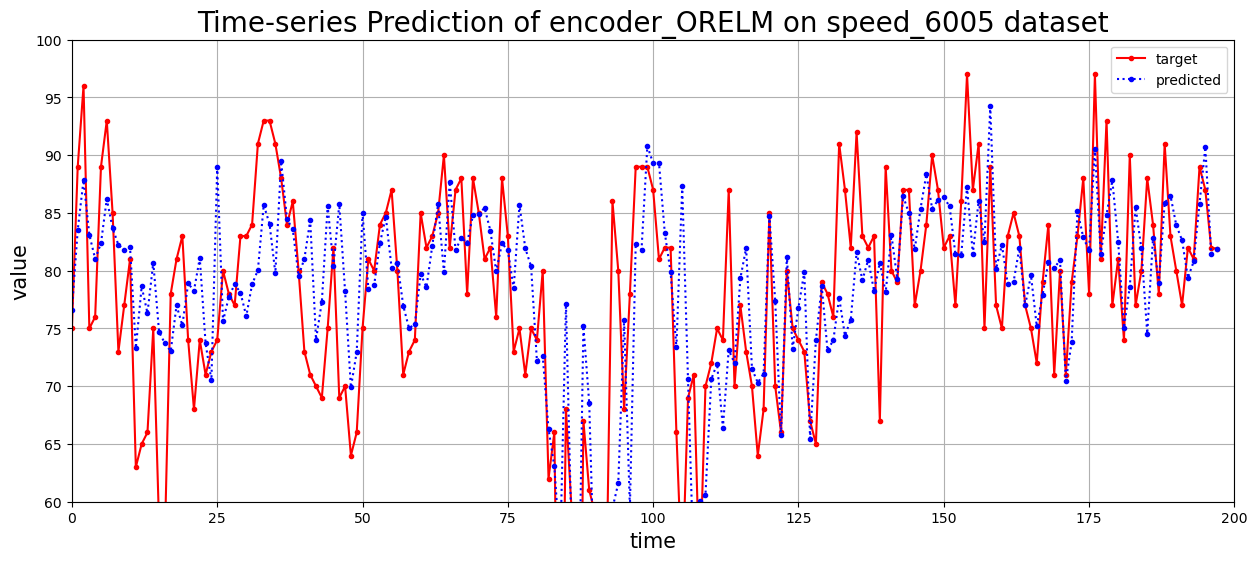

Prediction plot is saved to./predictionPlot.png


In [19]:
algorithm = config.job_type
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([0,200])
plt.ylim([60, 100])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.savefig(plot_path,bbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction plot is saved to'+plot_path)